In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import fastai
import fastai.vision
import time, copy
from pathlib import Path
import core

In [2]:
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch
import fastai
import fastai.vision
import time, copy
import core
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

path = Path('experiments')
exp_path = path/'FOOD_01'
config_path = exp_path/'config.pickle'

with open(config_path, 'rb') as handle:
    args = pickle.load(handle)


In [3]:
args

{'name': 'FOOD_01',
 'dataset': 'FOOD',
 'initial_splice': [[64, 1, 0], [128, 2, 0]],
 'splice': [[128, 2, 0]],
 'early_stop': True,
 'batch_size': 64,
 'image_size': 112,
 'stop_percent': 0.002,
 'seed': 229,
 'save': False,
 'max_lr': 0.0005,
 'num_epochs': 30,
 'n_trials': 3}

# Neural Splicing

Transfer learning has seen much success in the field of computer vision and more recently natural language processing. Specific approaches vary considerably, here we focus on extending a commonly used technique in which some of the weights and biases of a pre-trained model are loaded into a new architecture which is repurposed to some new tasks. This method has long since seen success in computer vision tasks and more recently in the field of natural language processing, popularized by Jeremy Howard and Sebastian Ruder in their paper introducing [ULMFiT ](https://arxiv.org/abs/1801.06146) and in Jeremy's [courses at fast.ai](https://course.fast.ai/) and later extended upon by folks at [google](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) (adding bidirectionality) and [open.ai](https://blog.openai.com/language-unsupervised/) (replacing LSTM core with a transformer), altogether resulting in many state-of-the-art NLP results.

Broadly speaking, this approach can be thought of as viewing a pretrained model as being composed of two pieces: a general-purpose *body* or *core* and a task-specific *head*. Thus far, applications of this approach involve replacing an existing *head* with a new one tailored for a specific task. Typically, in CV/NLP the core consists of the convolutional/recurrent components respectively, whereas the head is consist of pooling/flattening layers followed by a shallow multi-layer perceptron.

Here we investigate the question: why is in each of these cases the new component is added only **on top of** existing components? Can anything be gained by **splicing new components directly into the core architecture**?

Let us illustrate witha concrete example: suppose we has trained the following MLP for some regression task:

`
m = (nn.Sequential(nn.Linear(2,5), 
                   nn.ReLU(), 
                   nn.Linear(5,9), 
                   nn.ReLU(), 
                   nn.Linear(9,1)))
`

and one would like to add a layer *between* the first and second linear layer:

`
m_splice = (nn.Sequential(nn.Linear(2,5), 
                          nn.ReLU(), 
                          nn.Linear(5,5),      #Additional, un-trained component
                          nn.ReLU(), 
                          nn.Linear(5,9), 
                          nn.ReLU(), 
                          nn.Linear(9,1)))
`

Some observations: if the weights of the newly introduced layer are initialized randomly, then we can be certain that model performance will collapse. Since the original layers were trained together, layer two (nn.Linear(5,9)) *expects* inputs to look a certain way, (e.g look like something layer one would have output). Essentially this degradation would be the result of an extreme case of covariate shift which would defeat the purpose of using the pre-trained weights.

On the other hand, if we initialize the bias to zero and the weights to identity matrix, then the new layer has *no effect* on the model initially. Then if we freeze the learning rate on all the original layers, we can think of learning the weights of our new component as learning a post-processing of layer one output to be more 'palatable' for the rest of the network to consume in a similar spirit as batch-norm is introduced to post-process the output of layers to have desirable sample statistics. In practice, we anneal the learning rate on the layers surrounding the splice gradually from zero to some stable level while annealing the learning rate on the spliced component along a one cycle schedule as introduced [here](https://arxiv.org/abs/1708.07120). By monitoring gradient norms through the added component(s) as well as the original layers, one can propose a metric for determining the extent to which the architecture has 'accepted' or 'rejected' the new components. 

In this repo, we focus for now on convolutional and linear splicing and postpone experiments with splicing into recurrent architectures to a later date. Specifically, we are interested in exploring the following questions:

1) If we begin by training an architecture (A1) to some stop criterion (where reduction in loss is minimal, over overfitting begins to occur, etc.) and then splice in components to achieve architecture (A2), are we able to train (A2) further to achieve an overall lower loss (or else better performance by some specified metric)? 

2) Consider fully trained architecture (A2) above, along with full training history (pre- and post- splice, beginning from scratch). Make a copy of the architecture denoted (B2) and re-initialize weights randomly and train (B2) from scratch. We are interested:
* Does (B2) achieve worse, the same, or better *ultimate* performance (with a pre-defined stopping criterion specified a priori) as compared to (A2)
* How does the complete training history of (A2*) compare to that of (A2)? 
        
       
An affirmative response to question (1) suggests a cheap, fast procedure for incrementally increasing a trained model's performance if slight increase in performance is necessary for an application. 

A positive response to question (2) suggests alternative paradigms for training deep neural networks, rather than initializing a very deep network completely at random, perhaps it is faster, more efficient, or ultimately result in a better performance if one begins with a shallower network and gradually adds depth, splicing in layers over time and training them gradually. 

## Loading  data

We make use of fastai easy-to-use data block API for loading one of several common datasets to test our approach. 

In [ ]:
""" Loading the MNIST dataset...
url = fastai.datasets.URLs.MNIST
path = fastai.datasets.untar_data(url)
data = fastai.vision.ImageDataBunch.from_folder(path, train='training', valid='testing')
learn = fastai.vision.create_cnn(data, models.resnet18, metrics=accuracy)
"""

In [ ]:
""" Loading the CIFAR dataset...
url = fastai.datasets.URLs.CIFAR
path = fastai.datasets.untar_data(url)
data = (fastai.vision.ImageItemList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(fastai.vision.get_transforms(), size=224)
        .databunch(bs=64))
"""

In [ ]:
"""  Loading the PETS dataset ... 
func = lambda x: str(x)[46:].rstrip('.jpg1234567890').rstrip('_')
url = fastai.datasets.URLs.PETS
path = fastai.datasets.untar_data(url)
data = (fastai.vision.ImageItemList.from_folder(path/'images')
        .random_split_by_pct()
        .label_from_func(func)
        .transform(fastai.vision.get_transforms(), size=224)
        .databunch(bs=64))
"""

In [2]:
"""To load the FOOD dataset..."""
path = Path('/home/max/Desktop/datasets/food-101/images')
data = (fastai.vision.ImageItemList.from_folder(path)
        .random_split_by_pct()
        .label_from_folder()
        .transform(fastai.vision.get_transforms(), size=112)
        .databunch(bs=64))

In [2]:
func = lambda x: str(x)[46:].rstrip('.jpg1234567890').rstrip('_')
url = fastai.datasets.URLs.PETS
path = fastai.datasets.untar_data(url)
data = (fastai.vision.ImageItemList.from_folder(path/'images')
        .random_split_by_pct()
        .label_from_func(func)
        .transform(fastai.vision.get_transforms(), size=112)
        .databunch(bs=8))

## Fastai benchmark

While we're here might as well check out how fast.ai does on this task just to see how we're going along. You'll  notice how easy to use their API is (if you haven't checked it out yet, I highly recommend taking a look!)  Notice also we don't keep the pre-trained resnet weights for now since we're training our model from scratch too. 

In [88]:
learn = fastai.basic_train.Learner(data, model=core.cnn(nc=data.c), loss_func=nn.CrossEntropyLoss(), metrics=fastai.metrics.accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


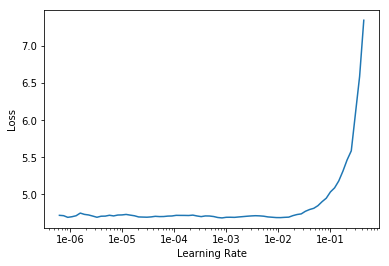

In [89]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy
1,4.075088,3.874008,0.118218
2,3.618849,3.475125,0.202030


In [ ]:
learn.fit_one_cycle(4, max_lr=1e-3)

In [ ]:
learn.fit_one_cycle(4, max_lr=1e-3)

In [ ]:
learn = fastai.basic_train.Learner(data, model=core.cnn(nc=data.c), loss_func=nn.CrossEntropyLoss(), metrics=fastai.metrics.accuracy)

In [ ]:
learn.fit_one_cycle(12, max_lr=1e-3)

## Set up 
Feel free to check out /.core for implementation details...

In [3]:
dls = {'train':data.train_dl, 'val':data.valid_dl}
model = core.cnn(nc=data.c).cuda()
model.init_opts()
model.init_params()
crit = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), betas=(0.65,0.95))

In [4]:
model.parameters() + model.parameters()

TypeError: unsupported operand type(s) for +: 'generator' and 'generator'

In [5]:
initial_splice = [[64,1,0], [64,1,0], [128,2,0]]

In [6]:
for nf, b_idx, i_idx in initial_splice:
    model.splice(nf=nf, b_idx=b_idx, i_idx=i_idx)

In [7]:
model.init_params()

In [11]:
opt = torch.optim.Adam(model.parameters())

In [10]:
old_model = copy.deepcopy(model)

TypeError: cannot unpack non-iterable NoneType object

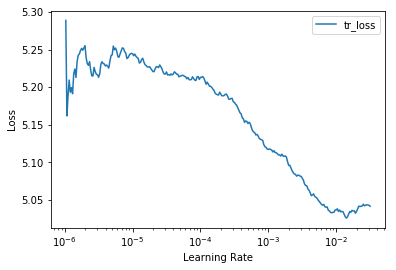

In [12]:
lrf = core.LearningRateFinder(opt, nits=300, min_lr=1e-6, max_lr=1e-1)
lrf.lr_find(model, data.train_dl, crit)

In [ ]:
model.fit(crit, dls, num_epochs=5)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp


class Smoother():
    def __init__(self, beta=0.95):
        self.beta, self.n, self.mov_avg = beta, 0, 0
        self.vals = []

    def add_value(self, val):
        self.n += 1
        self.mov_avg = self.beta * self.mov_avg + (1-self.beta)*val
        self.vals.append(self.mov_avg/(1-self.beta**self.n))

    def process(self,array):
        for item in array:
            self.add_value(item)
        return self.vals

    def reset(self):
        self.n, self.mov_avg, self.vals = 0,0,[]

class Stepper():
    def __init__(self, opt):
        self.it = 0
        self.opt = opt
        self.nits = 1

    def step(self):
        self.opt.step()

    def zero_grad(self):
        self.opt.zero_grad()
    
    @staticmethod
    def cosine_anneal(pct, max_val, min_val):
        return min_val + (max_val - min_val) / 2 *(1+np.cos(np.pi * pct))
    
    @staticmethod
    def exp_anneal(pct, start, stop):
        return start * (stop/start)**pct
    
    @staticmethod
    def linear_anneal(pct, start, stop):
        return (1-pct)*start + pct*stop

In [63]:
class LearningRateFinder(Stepper):
    def __init__(self, opt, nits=500, min_lr=1e-6, max_lr=1e-1):
        super(LearningRateFinder, self).__init__(opt)
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.pct_start = 0
        self.nits = nits
        for group in self.opt.param_groups:
            group['lr'] = min_lr
    
    def step(self):
        self.opt.step()
        self.it+=1 
        new_lr = self.exp_anneal(self.it / self.nits, self.min_lr, self.max_lr)
        for group in self.opt.param_groups:
            group['lr'] = new_lr
    
    def plot_lr_find(self,tr_history, clip=True):                                
        fig, ax = plt.subplots()
        if clip:
            start = int(0.05 * len(tr_history))
            end = int(0.90 * len(tr_history))
            tr_history = tr_history.iloc[start:end]
        ax.plot(tr_history.learning_rate, tr_history.tr_loss)
        ax.set_xscale('log')
        ax.legend()
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        rec_idx = self.suggest_lr(tr_history)
        rec_lr, rec_loss = tr_history.iloc[rec_idx].learning_rate, tr_history.iloc[rec_idx].tr_loss
        ax.plot([rec_lr],[rec_loss], 'x', color='k')
        plt.title('Suggested Learning Rate: {:.2E}'.format(rec_lr))
        return rec_lr

    def suggest_lr(self, tr_history, n_samples=200):
        tr_history = tr_history.reset_index(drop=True)
        
        pct_25 = int(0.25 * len(tr_history))
        pct_75 = int(0.75 * len(tr_history))
        
        start_samples = sorted(np.random.choice(tr_history.index[:pct_25], n_samples // 4, replace=False))
        middle_samples = sorted(np.random.choice(tr_history.index[pct_25:pct_75], n_samples // 2, replace=False))
        end_samples = sorted(np.random.choice(tr_history.index[pct_75:], n_samples // 4, replace=False))
        
        sample_idxs = np.array(start_samples + middle_samples + end_samples)
        xs = [x / len(tr_history) for x in sample_idxs]
        ys = tr_history.iloc[sample_idxs].tr_loss.values
        
        tck = sp.interpolate.splrep(xs, ys, t=[], k=3)
        line = sp.interpolate.splev(xs, tck, der=2)
        rec_pct = -line[0]/(line[-1] - line[0])
        rec_idx = int(rec_pct * len(tr_history))
        
        return rec_idx
    
    def lr_find(self, model, tr_dl, criterion, **kwargs):
        tr_losses = []
        lrs = []
        self.it = 0 
        old_params = model.state_dict()
        while self.it <= self.nits:
            for inputs, labels in tr_dl:
                if self.it > self.nits:
                    break
                self.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                self.step()
                tr_losses.append(loss.item())
                lrs.append(self.opt.param_groups[-1]['lr'])
        tr_losses = Smoother(beta=0.99).process(tr_losses)
        tr_history = pd.DataFrame({'tr_loss':tr_losses, 'learning_rate':lrs})
        rec_lr = self.plot_lr_find(tr_history)
        model.load_state_dict(old_params)
        return rec_lr, model

In [19]:
import pandas as pd; import numpy as np;  import scipy as sp

In [ ]:
df = pd.DataFrame({'test':np.arange(5000)})

In [ ]:
sorted(np.random.choice(df.index[:int(0.25*len(df))], 5, replace=False))

In [ ]:
url = fastai.datasets.URLs.MNIST
path = fastai.datasets.untar_data(url, force_download=True)
data = fastai.vision.ImageDataBunch.from_folder(path, train='training', valid='testing')


In [ ]:
n_samples = 200

In [ ]:
n_samples // 4